## 1. Introduction

[Airbnb](https://en.wikipedia.org/wiki/Airbnb) is a global online marketplace for arranging or offering lodging and experiences, it has grown to become one of the largest online marketplaces for lodging in the world, while New York City (NYC) is one of the most popular cities on Airbnb (refer [statistia](https://www.statista.com/chart/18963/most-popular-us-cities-for-airbnb-homeaway/)), which means the competition is also brutal. Therefore, it's vital to understand what users like and dislike and make improvements to enhance the overall customer experience.

In this project, we will perform text mining and sentiment analysis on 2018-2022 NYC Airbnb reviews found [here](http://insideairbnb.com/get-the-data/). Here is the list of dataset columns:

- `listing_id`: The identifier of the listing (the room provided to the reviewer)
- `id`: The identifier of the review
- `date`: Time the review posted, in the format of `year-month-day`
- `reviewer_id`: The identifier of the reviewer
- `reviewer_name`: Reviewer's name
- `comments`: The text of the review

## 2. Prepare
### 2.1 Loading the libraries

In [ ]:
library(tidyverse)
library(lubridate)
library(ggplot2)
library(ggraph)
library(igraph)
library(tidygraph)
library(ggmice)
library(gridExtra)
library(wordcloud2)
library(reshape2)
library(scales)
library(tidytext) # text mining
library(quanteda) # quantitative text analysis
library(udpipe) # tokenizing, lemmatising, tagging and dependency Parsing
library(textcat) # language identification
library(cld2) # language identification
options(readr.show_col_types = FALSE)

# set default theme options
theme_set(
  theme_minimal() + 
  theme(    
    plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
    axis.text = element_text(size = 14),
    axis.title = element_text(size = 16),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 14),
    strip.text = element_text(size = 14)
  )
)

### 2.2 Importing the data

In [2]:
df <- read_csv("data/reviews.csv")
head(df)

listing_id,id,date,reviewer_id,reviewer_name,comments
<dbl>,<dbl>,<date>,<dbl>,<chr>,<chr>
5803,1743,2009-04-23,9868,Pamela,"Artwork, indeed! The walls are covered with drawings by Maurice Sendak, Steven Kellogg, among others. It was quiet. Breakfast was ample. Batman and Robin were very affectionate. We plan to return again. Thanks, Laurie!"
2595,17857,2009-11-21,50679,Jean,"Notre séjour de trois nuits. <br/>Nous avons apprécier L'appartement qui est très bien situé. Agréable, propre et bien soigné. C'est idéal pour une famille de 3 ou 4 personnes. <br/>Petits soucis en arrivant il y avait personne pour nous recevoir, et il manquait le savon pour la douche, le liquide vaisselle, nous les avons reçu de surlendemain. Il y a aussi le bruit du Métro de NY, donc une première nuit difficile si on est pas habitué. Jennifer est correcte le remboursement de la caution était très rapide. A part ces petits détails notre court séjour c'est bien passé. <br/>Si j'ai la possibilité de revenir sur NY pour les vacances, je reprendrai à ""The Midtown Castle"" <br/>Jean <br/>Possession - Ile de La Réunion <br/>"
2595,19176,2009-12-05,53267,Cate,Great experience.
2595,19760,2009-12-10,38960,Anita,"I've stayed with my friend at the Midtown Castle for six days and it was a lovely place to be. A big spacious room with a pointy roof, which really makes you feel like staying in a castle. The location is perfect. It is just a few steps from Macy's Time Square and Theatre District. Everything worked just perfect with the keys etc. Thank you so much Jennifer, we had a great time in New York. <br/>Attention: it's on the 4th floor without a lift :-) but definetely worth it!"
2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, enjoying to be in the center of the city, that never sleeps...short ways to everywhere in Manhattan, by subway or by walk. Midtown castle is a beauftiful and tastful place, Jennifer and Tori relaxed and friendly hosts - thats why we - the three Berliners - recommand that place! Good to have WiFi and a little kitchen too!"
2595,46312,2010-05-25,117113,Alicia,We had a wonderful stay at Jennifer's charming apartment! They were very organized and helpful; I would definitely recommend staying at the Midtown Castle!


We can find something interesting in the random 10 rows, such as:
- There are reviews in languages other than English.
- There are `<br/>` in long reviews. 
 
We have to take those into account in our next analysis. Besides, `listing_id`, `id` and `reviewer_id` make more sense as strings.

#### Data size

In [3]:
# data size of original dataset
dim(df)

[1] 1088372       6

#### Summary statistics

In [4]:
summary(df)

   listing_id              id                 date           
 Min.   :2.595e+03   Min.   :1.743e+03   Min.   :2009-04-23  
 1st Qu.:7.951e+06   1st Qu.:2.813e+08   1st Qu.:2018-06-24  
 Median :2.165e+07   Median :6.042e+08   Median :2020-02-10  
 Mean   :3.808e+16   Mean   :2.434e+17   Mean   :2020-01-08  
 3rd Qu.:4.121e+07   3rd Qu.:5.832e+17   3rd Qu.:2022-03-15  
 Max.   :7.733e+17   Max.   :7.747e+17   Max.   :2022-12-04  
  reviewer_id        reviewer_name        comments        
 Min.   :        1   Length:1088372     Length:1088372    
 1st Qu.: 27751798   Class :character   Class :character  
 Median : 90587758   Mode  :character   Mode  :character  
 Mean   :136195313                                        
 3rd Qu.:212078766                                        
 Max.   :489891673                                        

The dataset contains more than 1 million reviews of NYC airbnbs between 2009-04-23 and 2022-12-04. The statistics indicates the number of reviews in the early years is far less than in recent years, because 2009-2018 (9 years) has about 25% of total reviews only. Therefore, we have a sufficient amount of data to get a clearer picture of recent trends, by analyzing the last 5 years (2018-2022) of reviews, .

To avoid skewed monthly analysis, we should remove the 4 days data in December, 2022.

<!-- #### Sampling -->

## 3. Process

### 3.1 Data filtering

This study will focus on 2018-2022 reviews.

In [5]:
df_filtered <- df %>% 
  filter(ymd("2018-01-01") <= date & date < ymd("2022-12-01")) # remove 2022-12-01 to 2022-12-04 data


### 3.2 Data cleaning && manipulation

Check missing values:

In [6]:
# the number of missing values
print(colSums(is.na(df_filtered)))

   listing_id            id          date   reviewer_id reviewer_name 
            0             0             0             0             0 
     comments 
           39 


Give the small size of missing values, it's OK to remove them.

In [7]:
# ignore missing values
df_clean <- df_filtered[complete.cases(df_filtered), ]
# remove html tags
df_clean$comments <- gsub("<.*/>", " ", df_clean$comments)

df_clean <- df_clean %>%
  distinct(comments, .keep_all = TRUE) %>% # remove duplicates
  filter(nchar(comments) > 1) %>% # remove reviews shorter than 1 character
  select(-c("reviewer_id", "reviewer_name")) %>%  # drop reviewer related columns
  mutate(listing_id = as.character(listing_id),
         id = as.character(id)
  ) %>% # convert id to character
  rename(reviews = comments) # rename column

### 3.3 English reviews

This study will only focus on English reviews. We've known that some of the comments are not in English, but in which languages and in what proportion?

Here we use [cld2](https://www.rdocumentation.org/packages/cld2/versions/1.2.1/topics/cld2) (R Wrapper for Google’s Compact Language Detector 2) library to idenfiy the languages of reviews.

In [8]:
# detect the review text's language by cld2
lan_group_cld2 <- detect_language(df_clean$reviews)
lan_df_cld2 <- data.frame(language = lan_group_cld2)
df_reviews <- cbind(df_clean, lan_df_cld2)

In [9]:
# check the first 6 rows
df_reviews %>% select(reviews, language) %>% head()

,reviews,language
,<chr>,<chr>
1,Great place. Would definitely recommend! Jennifer is really sweet and easy going.,en
2,"We really enjoyed our stay at Jennifer’s apartment. She was very hospitable and answered any questions we had promptly. The hike up the four flights of stairs with the luggage was a challenge. The location was amazing. Central to everything, 5 min walk to the subway, close to time square. There was a bit of noise at night from all the construction happening around the apartment but Jennifer supplied us with ear plugs which worked a treat. Would highly recommend her apartment",en
3,This apartment is convenient and functional. The huge skylight makes it feel open and airy. And it is located smack dab in the middle of Manhattan. Highly recommended.,en
4,The Midtown Castle is a beautiful place to stay in the center of the city. Truly a sanctuary with everything you need. Little touches of nature and beauty throughout. Waking up with the sun from the skylight was amazing.,en
5,Jennifer is very nice and responsive. The location of the apt is great. However However. We do appreciate the stay and the location,en
6,"Jennifer es un anfitrión increíble. Siempre estuvo comunicada y dejó listos todos los detalles para que mi estancia fuera perfecta. Me sentí como en casa. El departamento es maravilloso, con mucha luz y una sensación de tranquilidad, además de una ubicación inmejorable, justo en el centro de Manhattan!! A unos pasos del Empire State. Totalmente recomendable!!",es


List the main languages:

In [10]:
# textcat: list languages with share greater than 1%
df_reviews %>% 
  count(language) %>% 
  mutate(percentage = round(n/sum(n)*100, 1)) %>% 
  filter(percentage > 0) %>% 
  arrange(desc(n))

language,n,percentage
<chr>,<int>,<dbl>
en,743138,90.5
es,27257,3.3
fr,20233,2.5
NA,8041,1.0
de,6749,0.8
pt,3158,0.4
it,2951,0.4
zh,2077,0.3
ko,1647,0.2


**English** is the main language of those reviews (90.5%) and also this study's target language. Let's drop reviews of other languages.

In [11]:
df_reviews <- df_reviews %>% 
  filter(language == 'en') 
dim(df_reviews)

[1] 743138      5

The final data has 743,138 rows x 5 columns.

## Exploratory Data Analysis

###  4.2 Number of reviews over time

Let's have a basic understanding of the data, such as the trend in the number of reviews. Below is a bar plot that can display monthly reviews.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



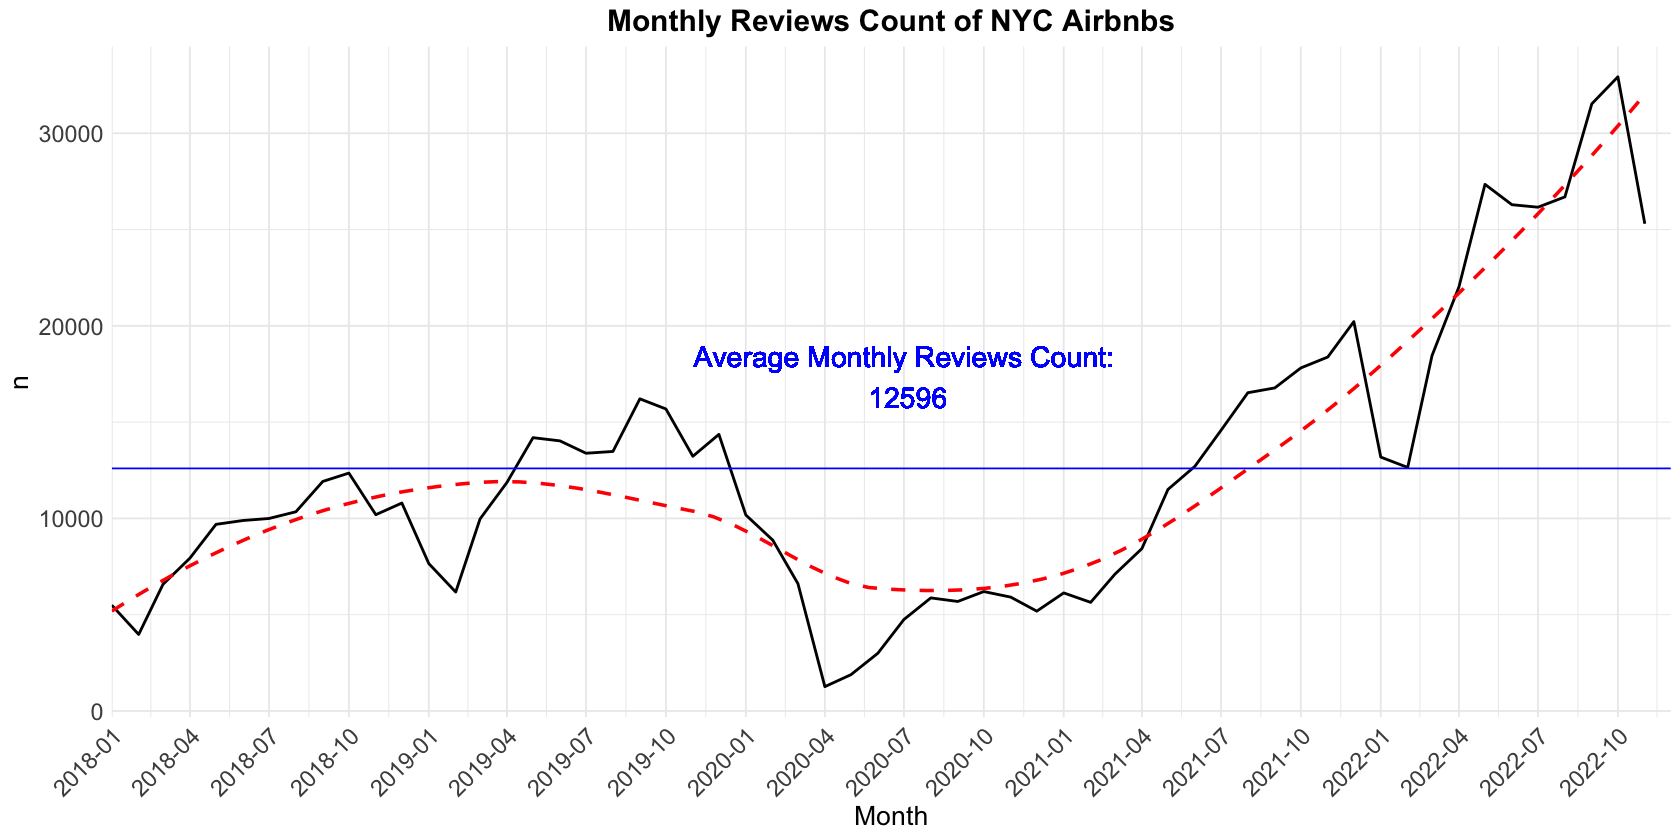

In [12]:
options(repr.plot.width = 14, repr.plot.height = 7)
df_date_group <- df_reviews %>%
  count(Month = round_date(date, "month"))

avg_review_cnt <- round(mean(df_date_group$n), 0)

df_date_group %>%
  ggplot(aes(Month, n)) +
  geom_line(size = 0.8) +
  geom_smooth(se = F, lty = 2, color="red") + 
  geom_hline(yintercept = avg_review_cnt, color="blue") +
  geom_text(aes(ymd("2020-07-01"), avg_review_cnt), 
            label = paste("Average Monthly Reviews Count:\n", avg_review_cnt),
            color="blue", vjust = -1, size = 6) +
  scale_x_date(date_breaks="3 month", 
               date_labels="%Y-%m", 
               limits = as.Date(c('2018-01-01','2022-12-01')),
               expand=c(0,0)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(title = "Monthly Reviews Count of NYC Airbnbs")

Overall, the number of reviews increases year over year but fluctuates seasonally, It decreased during winter (October-February) then increases the next season.

During 2020/03 - 2021/06, the number of reviews dropped rapidly due to COVID 19 and has since increased rapidly.

## 5. Text Mining

An patterns within those reviews? How does COVID 19 affect them? To answer such questions, let's explore the reviews by analyzing the popular words, [bigrams](https://en.wikipedia.org/wiki/Bigram) and [trigrams](https://en.wikipedia.org/wiki/Trigram), excluding stop words.

### 5.1 Most common words

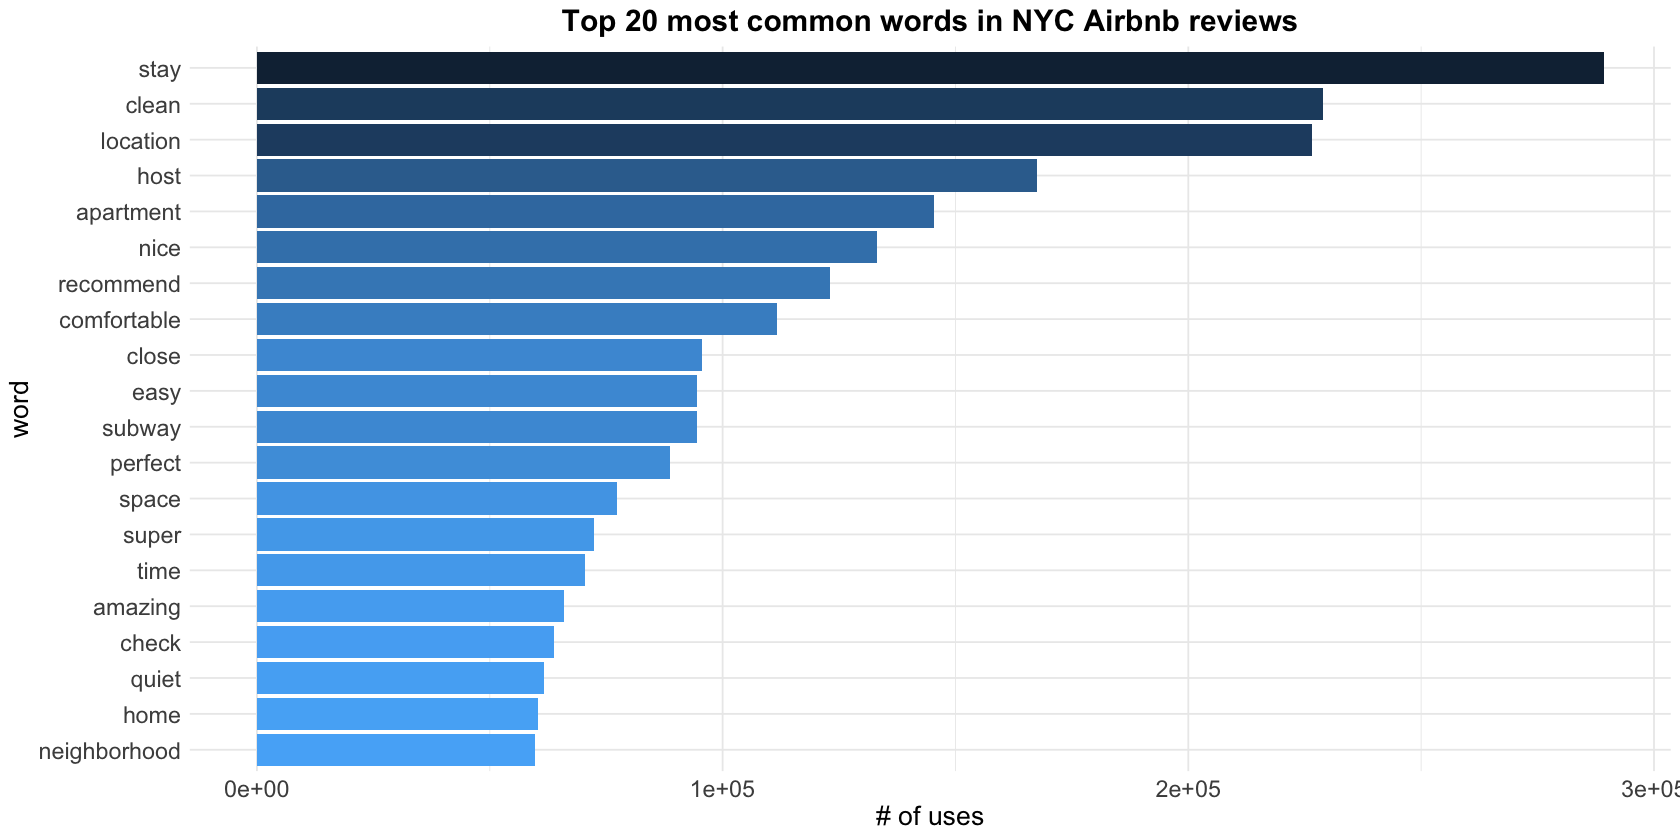

In [13]:
# English stop words
stop_words <- tidytext::stop_words

# create function to generate word tokens of reviews
generate_words <- function(df) {
  words <- df %>%
    mutate(line_num = row_number()) %>% 
    unnest_tokens(word, reviews, drop = FALSE) %>%
    distinct(line_num, word, .keep_all = TRUE) %>%
    anti_join(stop_words, by = "word") %>% # ignore stop words 
    filter(str_detect(word, "[^\\d]"))
  return(words)
}

barplot_word_freq <- function(words, n_rank=20, title, facet_wrap_language=FALSE, colors) {
  if (!facet_wrap_language) {
    words %>%
      count(word, sort = TRUE) %>% 
      head(n_rank) %>%
      mutate(word = reorder(word, n)) %>% 
      ggplot(aes(word, n, fill = -n)) +
      geom_col() +
      coord_flip() +
      theme(legend.position = "none") +
      labs(y = "# of uses", title = title) 
  } else {
    words %>%
      count(language, word, sort = TRUE) %>% 
      group_by(language) %>%
      top_n(n_rank) %>%
      mutate(word = reorder(word, n)) %>% 
      ggplot(aes(word, n, fill = language)) +
      scale_fill_manual(values = colors) +
      geom_col() +
      coord_flip() +
      facet_wrap(~ language, scales = "free") + 
      theme(legend.position = "none") +
      labs(y = "# of uses", title = title)
  }
}

words <- generate_words(df_reviews)

barplot_word_freq(words, 20, "Top 20 most common words in NYC Airbnb reviews")

Among the top 20 most common words, the 2nd to 5th popular words are "clean", "location", "host", and "apartment", they contain important information.

A reasonable assumption is apartment is one of the most popular listing types in NYC Airbnb, and guests care most about the cleanliness, location (especially subway) and service the host provides. 

Let's continue our analysis and see if we can find evidence to support that assumption.

### 5.2 Important words trending in reviews

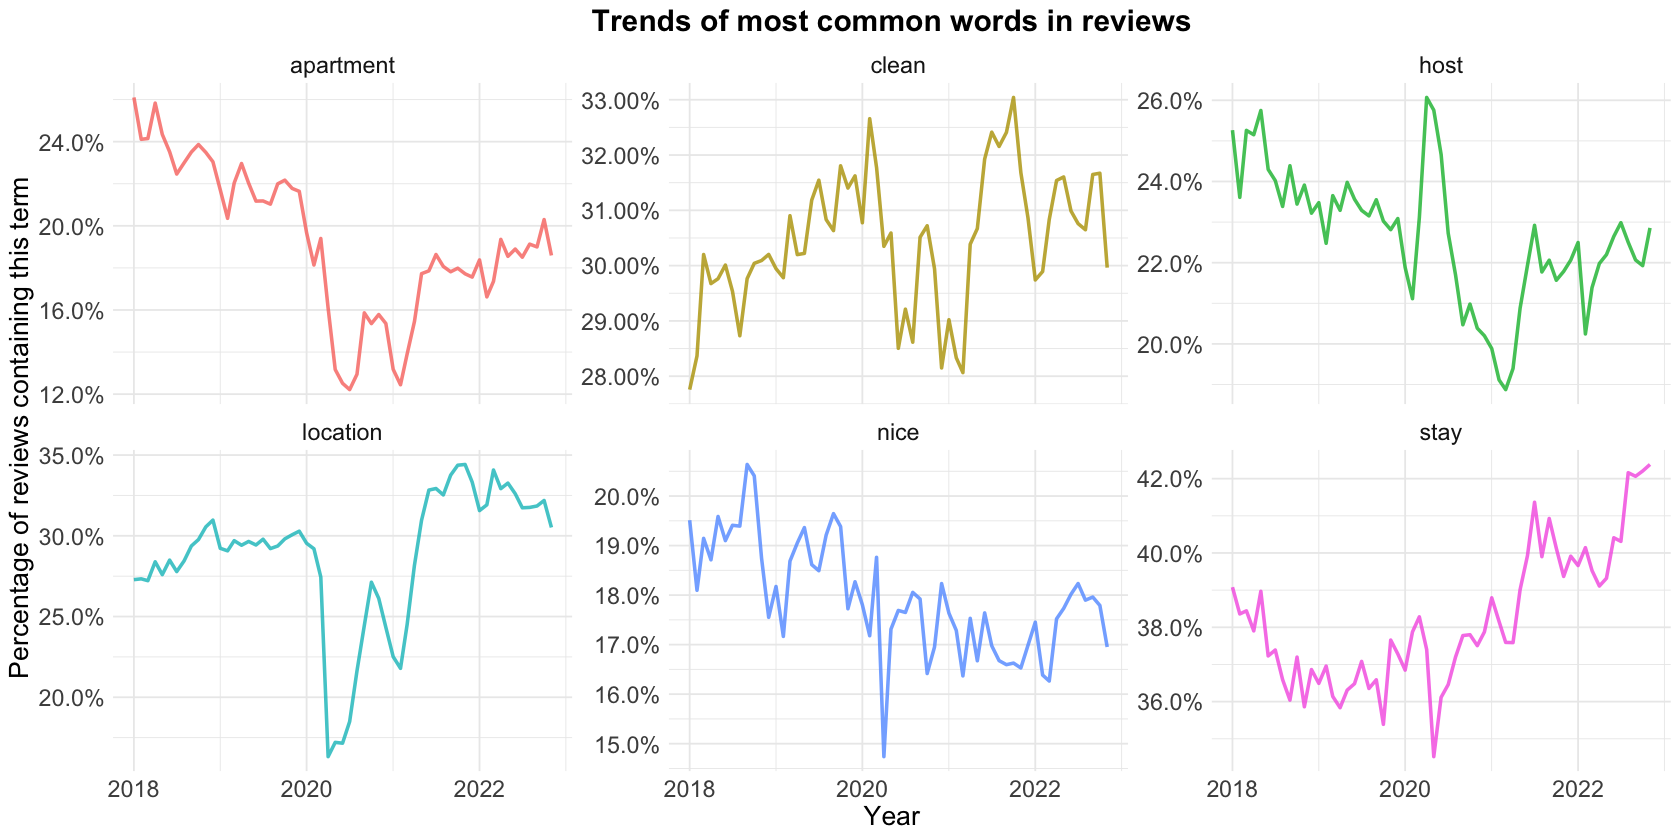

In [14]:
# plot monthly trend of selected words
plot_word_trend <- function (df, words, word_filter, title) {
  reviews_per_month <- df %>%
    mutate(month = round_date(date, "month")) %>% 
    group_by(month) %>%
    summarize(month_total = n())

  # count word monthly percentage
  word_month_counts <- words %>%
    mutate(month = round_date(date, "month")) %>% 
    count(word, month) %>%
    complete(word, month, fill = list(n = 0)) %>%
    inner_join(reviews_per_month, by = "month") %>%
    mutate(percent = n / month_total) %>%
    mutate(year = year(month) + yday(month) / 365) 

  word_month_counts %>%
    filter(word %in% word_filter) %>%
    ggplot(aes(month, n / month_total, color = word)) +
    geom_line(size = 1, alpha = .8) +
    scale_y_continuous(labels = percent_format()) +
    facet_wrap(~ word, scales = "free_y") +
#     expand_limits(y = 0) +
    theme(legend.position = "none") +
    labs(x = "Year",
         y = "Percentage of reviews containing this term", 
         title = title)    
}

# The top 6 most common words
word_filter <- c("stay", "clean", "location", "apartment", "host", "nice")

plot_word_trend(df_reviews, words, word_filter, "Trends of most common words in reviews")

The popularity of "stay", "location", "clean" is slowly increasing, while the others are decreasing.

### 5.3 Bigrams

A [bigram](https://en.wikipedia.org/wiki/Bigram) is a sequence of two adjacent elements from a string of tokens, which are typically letters, syllables, or words. A bigram is an n-gram for n=2.

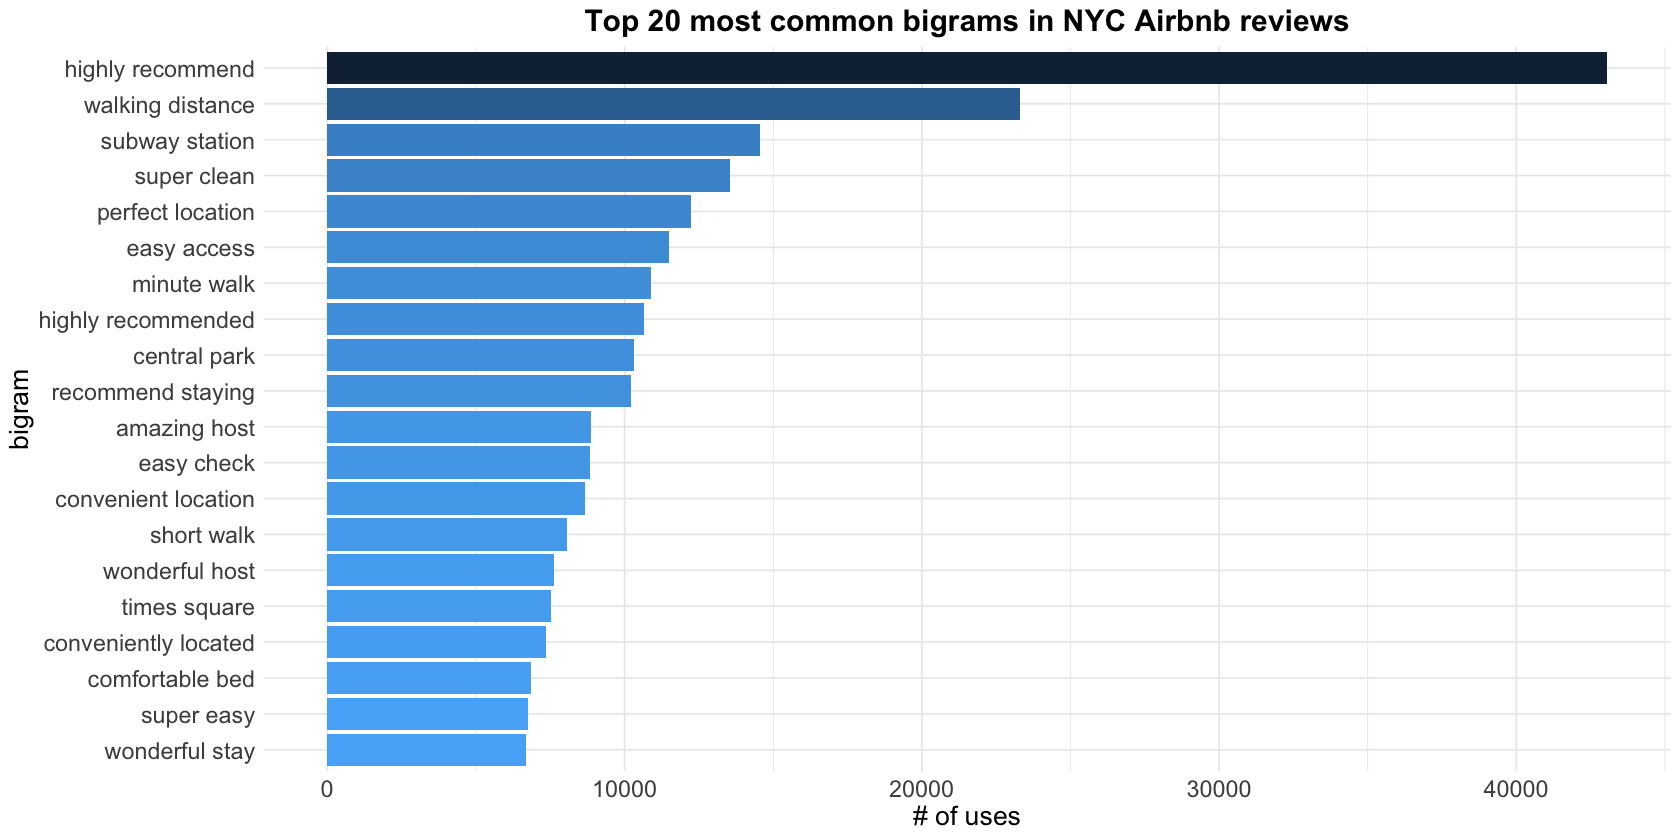

In [16]:
review_tokens <- df_reviews %>% 
  unnest_tokens(bigram, reviews, token = "ngrams", n = 2)

review_separated <- review_tokens %>% 
  separate(bigram, into = c("word1", "word2"), sep = " ")

review_separated_words <- review_separated %>% 
  filter(!word1 %in% stop_words$word) %>%
  filter(!word2 %in% stop_words$word)

review_bigrams <- review_separated_words %>% 
  unite(bigram, c(word1, word2), sep = " ")

review_bigrams %>%
  count(bigram, sort = TRUE) %>% 
  head(20) %>% 
  mutate(bigram = reorder(bigram, n)) %>%
  ggplot(aes(bigram, n, fill = -n)) +
  geom_col() +
  coord_flip() +
  theme(legend.position = "none") +
  labs(y = "# of uses", title = "Top 20 most common bigrams in NYC Airbnb reviews")

Of those most common English bigrams, 10 of them are **location** related, such as "walking distance", "subway station", "central park", "times square", etc., Among accommodation-related words, **super clean** ranks much higher than "comfortable bed".
Moreover, both "amazing host" and "wonderful host" are compliments to the **host**.

That proves the importance of location, cleanliness and hosts.

### 5.4 Bigrams network

The network of bigrams shows how words are connected to each other.

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'can’t' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'can’t' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'can’t' in 'mbcsToSbcs': dot substituted for <99>”


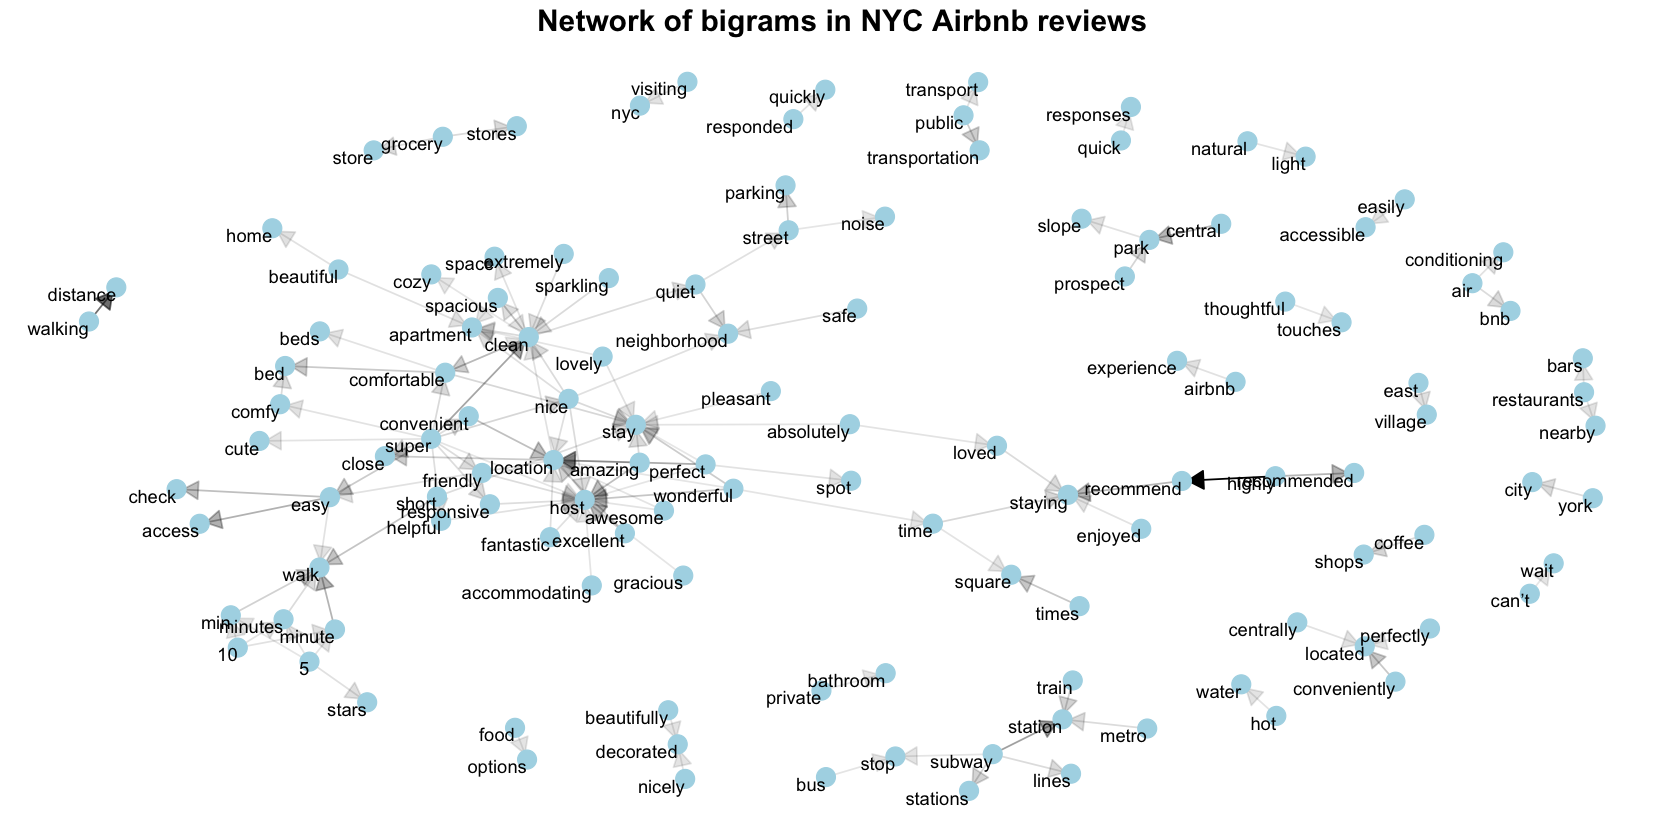

In [17]:
bigram_counts <- review_separated_words %>% 
  count(word1, word2, sort = TRUE) 

bigram_graph <- bigram_counts %>% 
  filter(n >= 2000) %>%
  as_tbl_graph()

arrow <- grid::arrow(type = "closed", length = unit(.15, "inches"))

ggraph(bigram_graph, layout = "fr") + 
  geom_edge_link(aes(alpha = n), show.legend = F, 
                 arrow = arrow, end_cap = circle(0.05, "inches")) + 
  geom_node_point(color = "lightblue", size = 5) + 
  geom_node_text(aes(label = name), vjust = 1, hjust = 1) +
  labs(title = "Network of bigrams in NYC Airbnb reviews")

The graph shows popular bigrams that occur at least 2000 times. According to the graph, words like "stay", "apartment", "clean" and "host" have strong connections with many other words, but there is no clear clustering structure.

### 5.5 Trigrams

Similar to Bigrams, [Trigram](https://en.wikipedia.org/wiki/Trigram) (n-gram=3) is a three-word sequence of words. Let's get the top 20 most popular trigrams.

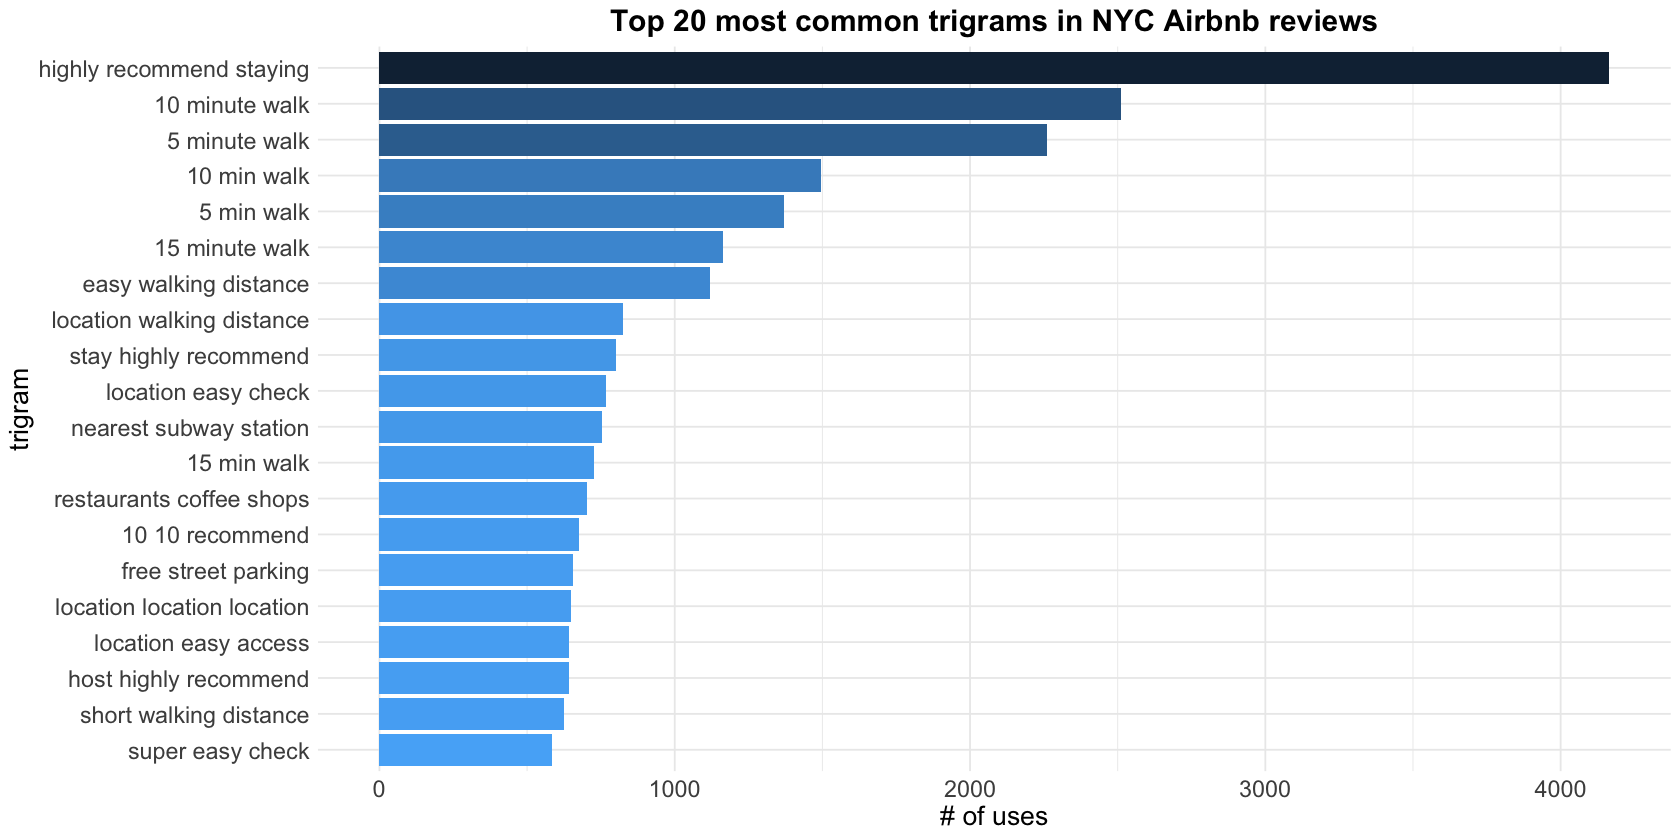

In [18]:
get_trigrams <- function(df) {
  review_tokens_tri <- df %>% 
    unnest_tokens(trigram, reviews, token = "ngrams", n = 3)

  review_separated_tri <- review_tokens_tri %>% 
    separate(trigram, into = c("word1", "word2", "word3"), sep = " ")

  review_trigrams <- review_separated_tri %>% 
    filter(!is.na(word1) & (!word1 %in% stop_words$word)) %>%
    filter(!is.na(word2) & (!word2 %in% stop_words$word)) %>%
    filter(!is.na(word3) & (!word3 %in% stop_words$word)) %>%
    unite(trigram, c(word1, word2, word3), sep = " ")
    
  return(review_trigrams)
}

review_trigrams <- get_trigrams(df_reviews)

review_trigrams %>%
  count(trigram, sort = TRUE) %>% 
  head(20) %>% 
  mutate(trigram = reorder(trigram, n)) %>%
  ggplot(aes(trigram, n, fill = -n)) +
  geom_col() +
  coord_flip() +
  theme(legend.position = "none") +
  labs(y = "# of uses", title = "Top 20 most common trigrams in NYC Airbnb reviews")

Trigrams are heavily related to **minute walk**, it's also one of the most common bigrams.

### 5.6 Word clouds

The key phrase "minute walk"(and "min walk") show up in both common bigrams and trigrams, which indicates many reviewers walk and they care about the walking time. Let's visualize the walking starting and ending points by wordclouds.

#### Walking starting points

In [19]:
start_keywords <- c(phrase("minute walk from*"), 
                    phrase("min walk from*"),
                    phrase("minutes walk from*"),
                    phrase("mins walk from*"))

wordcloud_by_keywords <- function(df, keywords) {
  review_tokens <- tokens(df$reviews)      
  # get sentences with keywords
  kw <- kwic(review_tokens, pattern = keywords)  
  # group by start points
  word_count <- kw %>% 
    unnest_tokens(word, post, drop = FALSE) %>% 
    anti_join(stop_words, by = "word") %>% 
    filter(str_detect(word, "[^\\d]")) %>% 
    count(word, sort = TRUE)

  wordcloud2(word_count, rotateRatio = 0, widgetsize =c("700","350"))    
}

wordcloud_by_keywords(df_reviews, start_keywords)

HTML widgets cannot be represented in plain text (need html)

#### Walking ending points

In [21]:
end_keywords <- c(phrase("minute walk to*"),
                  phrase("min walk to*"),
                  phrase("minutes walk to*"),
                  phrase("mins walk to*"))

wordcloud_by_keywords(df_reviews, end_keywords)

HTML widgets cannot be represented in plain text (need html)

Walking from/to **subway (station)** are most mentioned in reviews, followed by **train station**. 

## 6. Sentiment Analysis

Seems most common bigrams and trigrams in reviews are positive words, such as "highly recommended", does that mean most reviews are positive? What may cause negative reviews?
We can get the answers by sentiment analysis. 

First of all, let's find out the most positive and negative words, with the help of [AFINN lexicon](https://search.r-project.org/CRAN/refmans/textdata/html/lexicon_afinn.html).

### 6.1 Positive and negative words

Joining, by = "word"


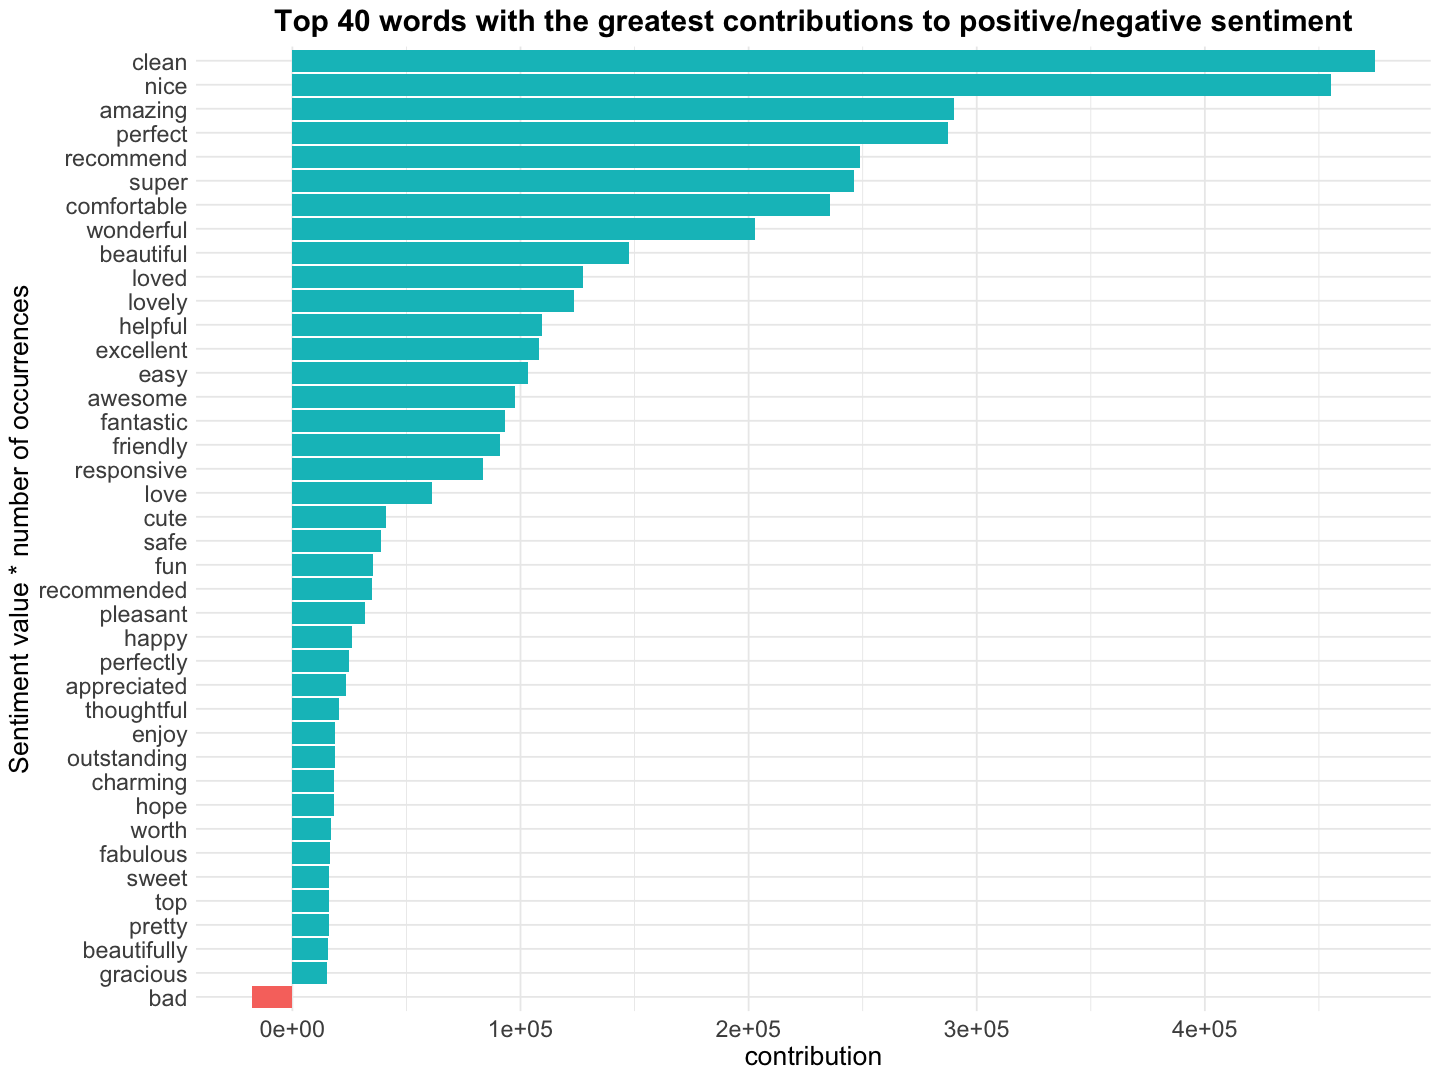

In [22]:
options(repr.plot.width = 12, repr.plot.height = 9)

words <- df_reviews %>%
  unnest_tokens(word, reviews) %>%
  anti_join(stop_words)

contributions <- words %>%
  inner_join(get_sentiments("afinn"), by = "word") %>%
  count(word, value) %>% 
  mutate(contribution = n * value)

contributions %>%
  top_n(40, abs(contribution)) %>%
  mutate(word = reorder(word, contribution)) %>%
  ggplot(aes(word, contribution, fill = contribution > 0)) +
  geom_col(show.legend = FALSE) +
  coord_flip() +
  labs(x = "Sentiment value * number of occurrences", title = "Top 40 words with the greatest contributions to positive/negative sentiment")

There is only one negative word "bad" in the first 40 words, and the negative sentiment value is very small.
Does that mean most reviews are positive? The answer is uncertain. We still need to know the context of these words. For example, when a positive word is preceded by a negative word like "not", it becomes a negative word.

### 6.2 Context of positive/negative words

Let's pick 6 common words "don't", "no", "not", "nothing", "wasn't", "without" and check how often words are preceded by them.

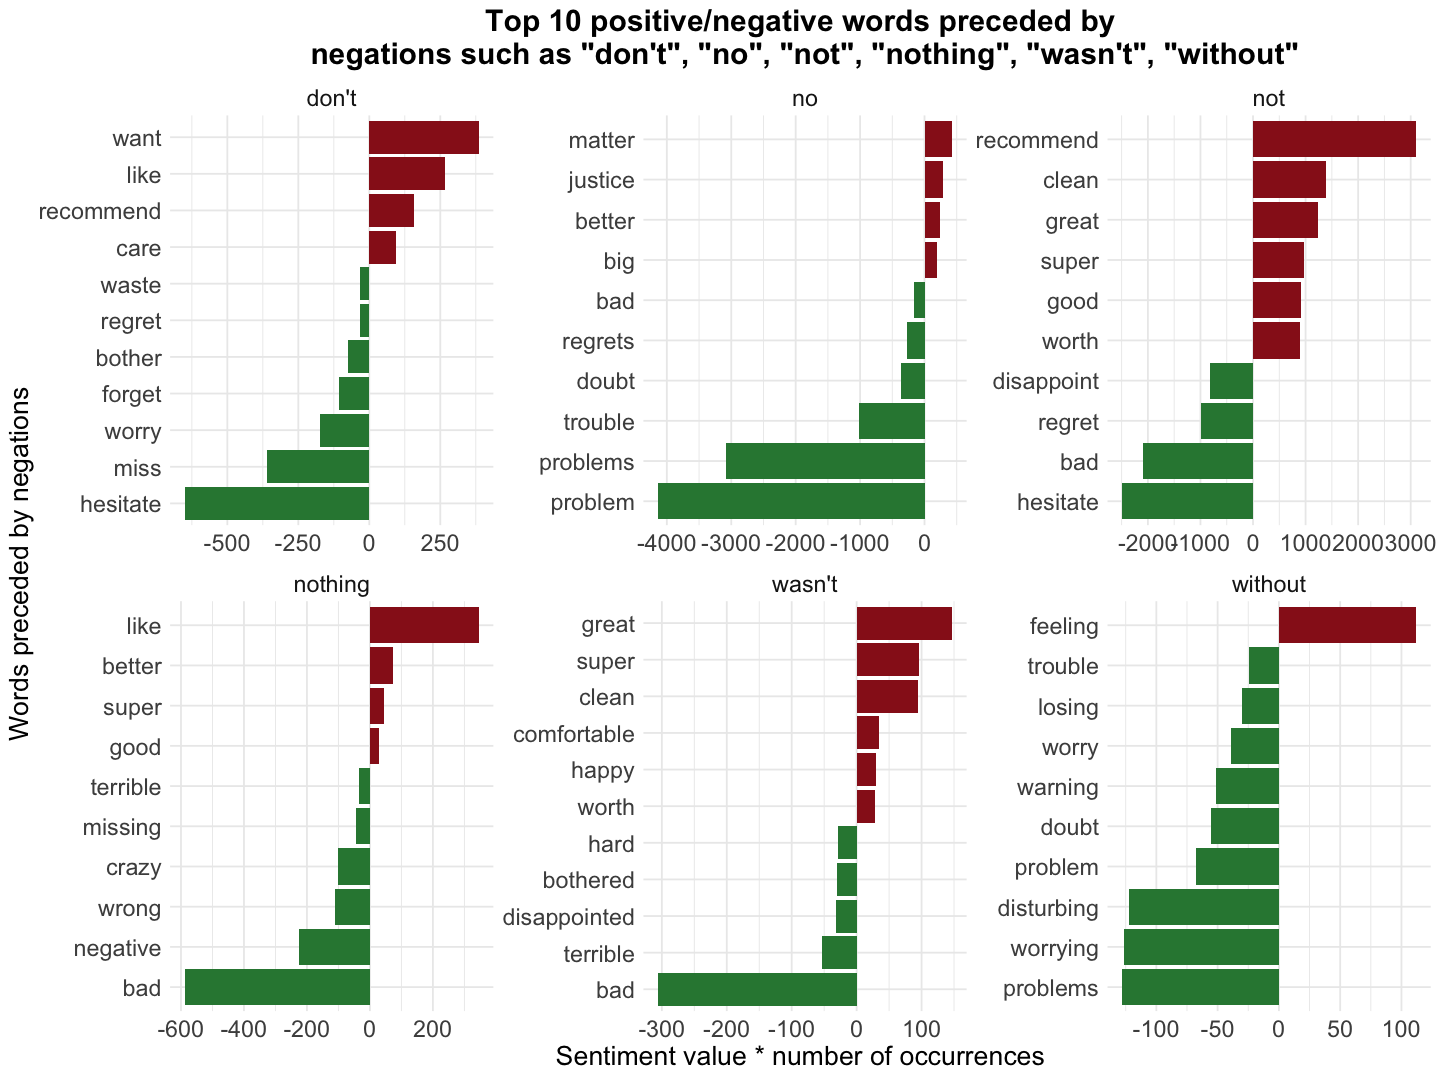

In [23]:
options(repr.plot.width = 12, repr.plot.height = 9)

rank_context_words <- function(data_separated, negation_words, n_rank, title) {
  negated_words <- data_separated %>%
    filter(word1 %in% negation_words) %>%
    inner_join(get_sentiments("afinn"), by = c(word2 = "word")) %>%
    count(word1, word2, value, sort = TRUE)

  p <- negated_words %>%
    mutate(contribution = n * value) %>%
    group_by(word1) %>% 
    top_n(n_rank, abs(contribution)) %>%
    ungroup() %>%
    ggplot(aes(y = reorder_within(word2, contribution, word1), 
               x = contribution, 
               fill = contribution > 0)) +
    scale_fill_manual(values = c("#2e8540", "#981b1e")) +
    geom_col(show.legend = FALSE) + 
    scale_y_reordered() + 
    facet_wrap(~ word1, scales = "free") + 
    theme(plot.title = element_text(size = 18)) +
    labs(title = title,
         y = "Words preceded by negations",
         x = "Sentiment value * number of occurrences")
    
  return(p)
}

negation_words <- c("wasn't", "no", "not", "nothing", "without", "don't")
rank_context_words(review_separated, negation_words, 10,
                   title = paste("Top 10 positive/negative words preceded by\n",
                                 'negations such as "don\'t", "no", "not", "nothing", "wasn\'t", "without"'))

The bigrams **no problems** and **no problem** are the largest sources of misidentifying as negative sentiment, and the largest source of incorrectly classified positive sentiment are **not recommend** and **not clean**.

### 6.3 Words that are linked to negative words

Why some reivews contain negative words? What disastified those reviewers? Let's use the [udpipe](https://bnosac.github.io/udpipe/docs/doc1.html) package to find out what words are are associated with those negative words. It's a time-consuming to process all 743K+ reviews, here let's focus on its random sample with 10% of the original data. The result should be very close to the original one.

In [32]:
df_reviews_subset <- df_reviews %>% 
  sample_n(round(nrow(df_reviews)/10,0), replace = FALSE, prob = NULL)

# step 1: tokenizing
udpipe_tokens <- df_reviews_subset %>% 
  rename(doc_id = id, text = reviews) %>%
  udpipe("english-gum")

In [33]:
# get lexicons
load(url("https://github.com/SentometricsResearch/sentometrics/blob/master/data-raw/FEEL_eng_tr.rda?raw=true"))
load(url("https://github.com/SentometricsResearch/sentometrics/blob/master/data-raw/valence-raw/valShifters.rda?raw=true"))

polarity_terms <- rename(FEEL_eng_tr, term = x, polarity = y)
polarity_negators <- subset(valShifters$valence_en, t == 1)$x
polarity_amplifiers <- subset(valShifters$valence_en, t == 2)$x
polarity_deamplifiers <- subset(valShifters$valence_en, t == 3)$x

# step 2: starting sentiment analysis
sentiments <- txt_sentiment(udpipe_tokens, term = "lemma", 
                            polarity_terms = polarity_terms,
                            polarity_negators = polarity_negators, 
                            polarity_amplifiers = polarity_amplifiers,
                            polarity_deamplifiers = polarity_deamplifiers)
sentiments <- sentiments$data

# step 3: get reasons (token_parent and lemma_parent) of negative words
reasons <- sentiments %>% 
  cbind_dependencies() %>%
  select(doc_id, lemma, token, upos, sentiment_polarity, token_parent, lemma_parent, upos_parent, dep_rel) %>%
  filter(sentiment_polarity < 0)

`summarise()` has grouped output by 'lemma'. You can override using the
`.groups` argument.
Warning message:
“`data_frame()` was deprecated in tibble 1.1.0.
Please use `tibble()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


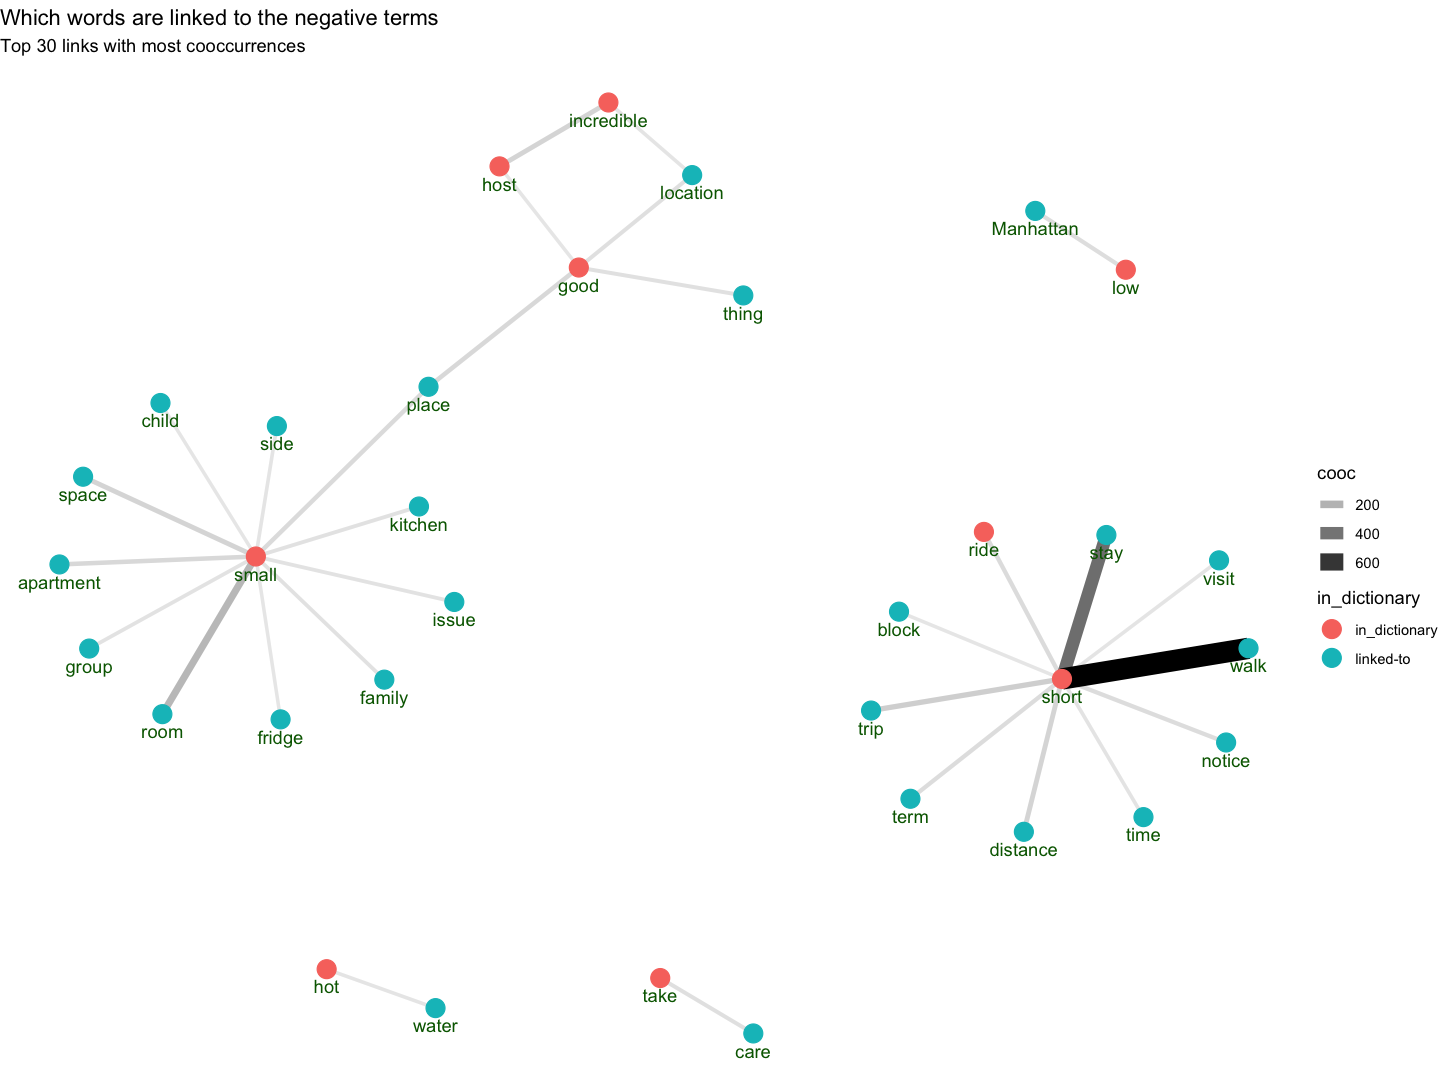

In [35]:
plot_negative_network <- function(reasons) {
  # group by negative words and parent words
  # amod: adjectival phrase that serves to modify the noun
  reasons_filtered <- filter(reasons, dep_rel %in% "amod") 
  word_cooccurences <- reasons_filtered %>% 
    group_by(lemma, lemma_parent) %>%
    summarise(cooc = n()) %>%
    arrange(-cooc) %>% 
    ungroup()

  # distinguish negative words from parent words
  vertices <- bind_rows(
    data_frame(key = unique(reasons_filtered$lemma)) %>% 
      mutate(in_dictionary = if_else(key %in% polarity_terms$term, 
                                   "in_dictionary", "linked-to")),
    data_frame(key = unique(setdiff(reasons_filtered$lemma_parent, reasons_filtered$lemma))) %>% 
      mutate(in_dictionary = "linked-to"))

  # visualization of top 30 pairs of negative words and parent words
  cooc <- head(word_cooccurences, 30)
  set.seed(1)
  cooc %>%  
    graph_from_data_frame(vertices = filter(vertices, key %in% c(cooc$lemma, cooc$lemma_parent))) %>%
    ggraph(layout = "fr") +
    geom_edge_link0(aes(edge_alpha = cooc, edge_width = cooc)) +
    geom_node_point(aes(colour = in_dictionary), size = 5) +
    geom_node_text(aes(label = name), vjust = 1.8, col = "darkgreen") +
    labs(title = "Which words are linked to the negative terms",
         subtitle = "Top 30 links with most cooccurrences") +
    theme_void()       
}

plot_negative_network(reasons)

According to the graph above, "short walk" has the strongest co-occurrence as negative words with term "short", however, those words are not negative in real life. For example, "short trip/stay" is neutral while "short distance" is probably positive.

Similarly, "incredible host" is also positive and "low manhattan" is a noun. We need to filter out those words to get more accurate network graph.

`summarise()` has grouped output by 'lemma'. You can override using the
`.groups` argument.


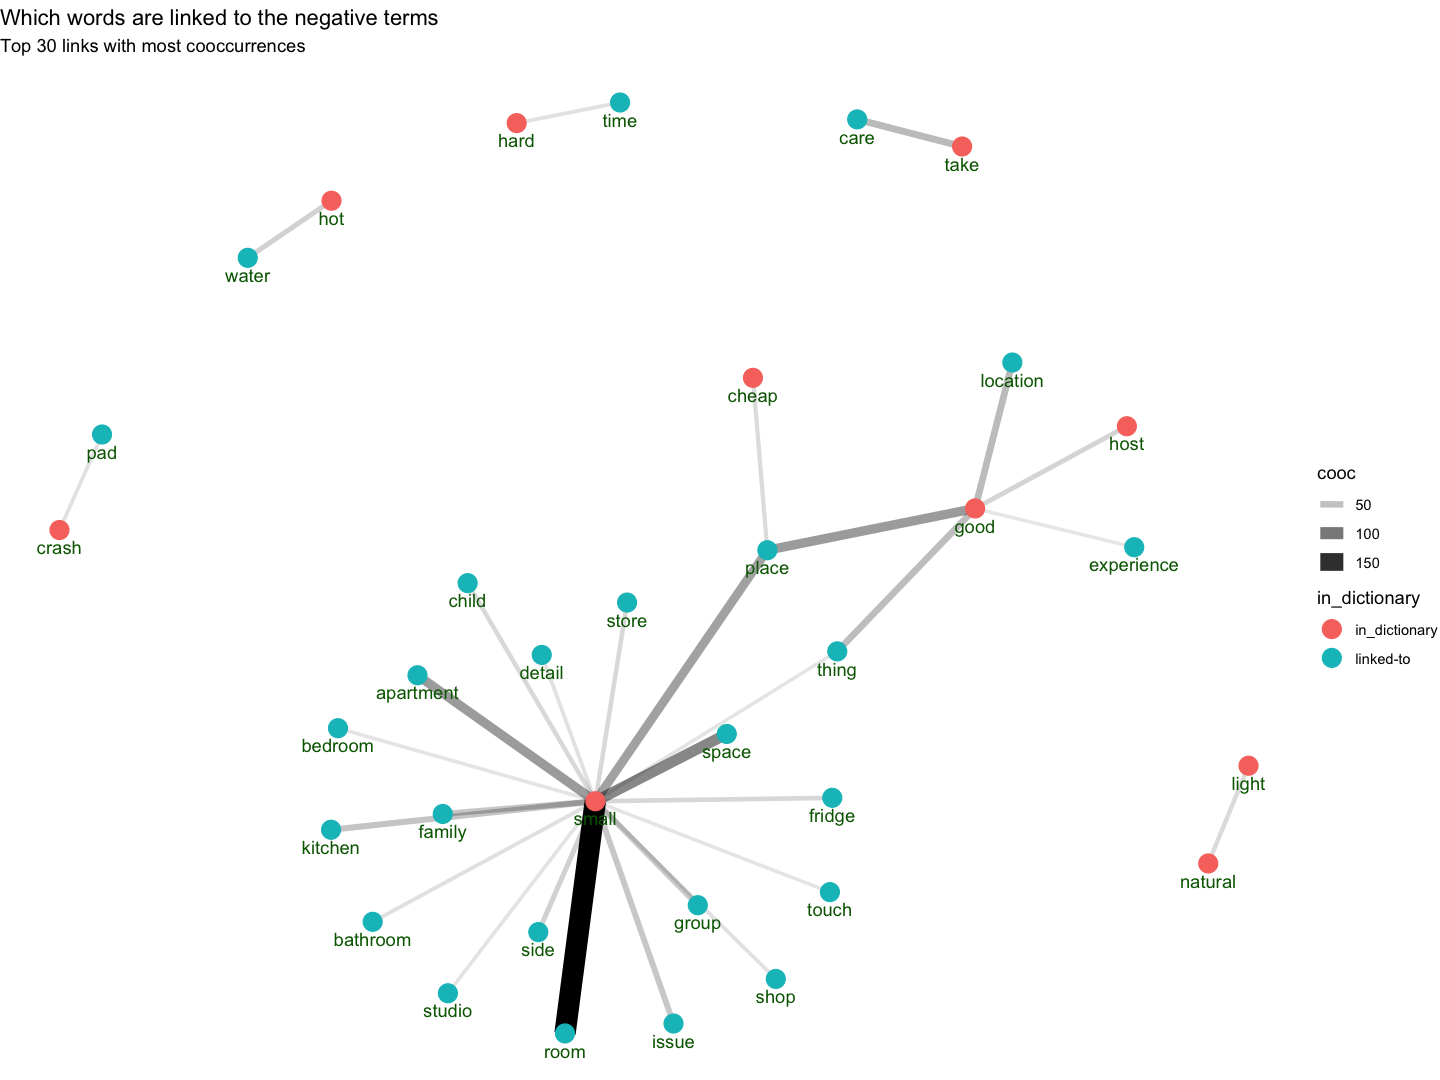

In [36]:
# filter out words that misindentified as negative
reasons_filtered <- reasons %>%
  filter(!token %in% c("short", "incredible")
         & token_parent != "Manhattan")

plot_negative_network(reasons_filtered)

This time, we did find something meaningful from the graph above. **small room** is the biggest reason of negative reviews, followed by small apartment/space, small place, and good place (from reviewers who might don't agree it's a good place). Besides, Airbnb hosts might also need to take care of issues such as **hot water** and **natural light**. 

### 6.4 Emotions

We can get sentiment scores of reviews based on the [
NRC Word-Emotion Association Lexicon](http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm), which provides a list of English words and their associations with eight basic emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust) and two sentiments (negative and positive).

Joining, by = "word"


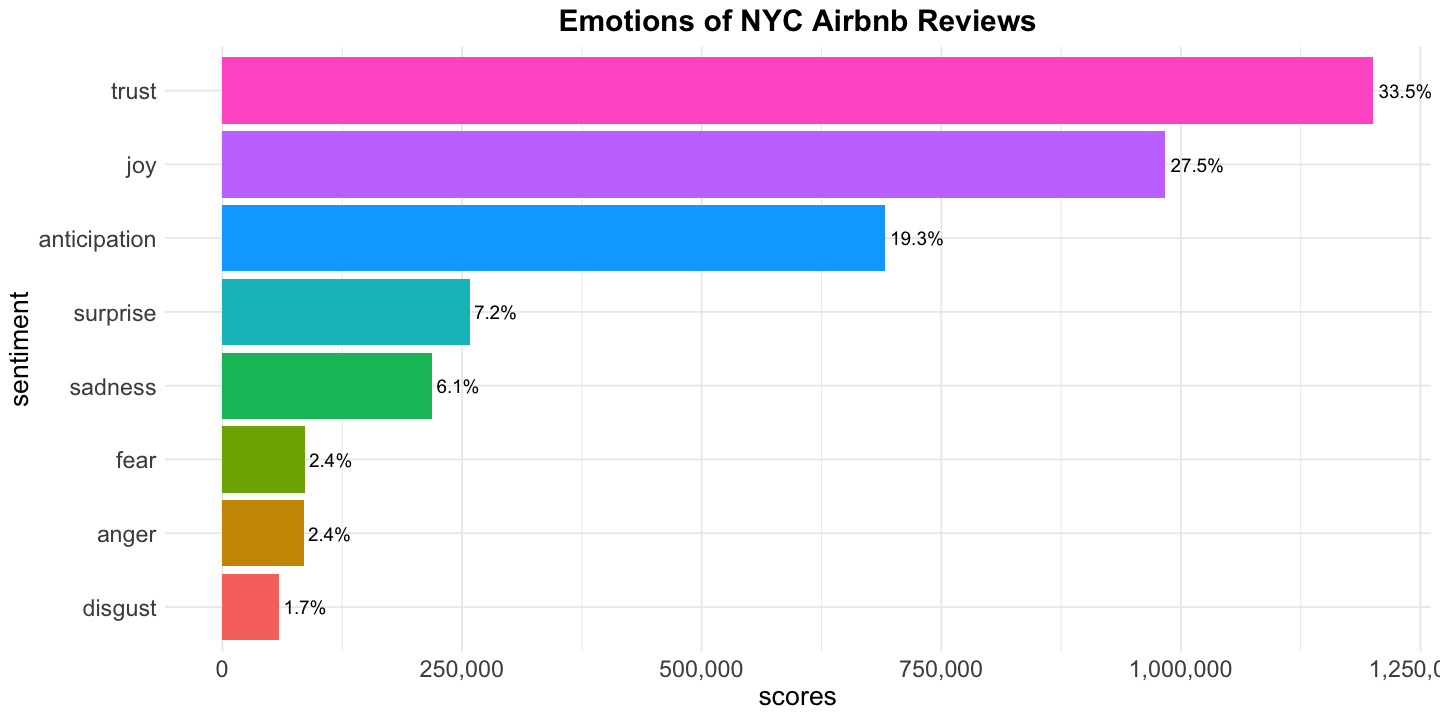

In [38]:
options(repr.plot.width = 12, repr.plot.height = 6)

# download the lexicon from http://saifmohammad.com/WebDocs/Lexicons/NRC-Emotion-Lexicon.zip
# save it to file/nrc/NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-v0.92/
words_nrc <- words %>%
  left_join(textdata::lexicon_nrc(dir="file", delete=TRUE, manual_download = TRUE)) %>% 
  filter(!is.na(sentiment))

words_emotions <- words_nrc %>% filter(!sentiment %in% c("positive", "negative"))

words_sentiments <- words_nrc %>% filter(sentiment %in% c("positive", "negative"))

barplot_sentiment <- function(df, title) {
  df %>%
    count(sentiment) %>%
    arrange(desc(n)) %>% 
    mutate(sentiment = reorder(sentiment, n), 
           pct = n/sum(n), 
           label = paste0(round(pct * 100, 1), "%")) %>% 
    rename(scores = n) %>% 
    ggplot(aes(x = sentiment, y = scores, fill = sentiment, label = label)) +
    geom_col(position = 'dodge') +
    coord_flip() +
    scale_y_continuous(labels = scales::comma) +
    geom_text(position = position_dodge(width = .9),
              vjust = 0.5,
              hjust = -0.1,
              size = 4) +
    theme(legend.position="none") +
    labs(title = title)    
}

barplot_sentiment(words_emotions, "Emotions of NYC Airbnb Reviews")

The top 3 sentiment/emotions are **trust**, **joy**, and **anticipation**. What about the positive and negative valence?

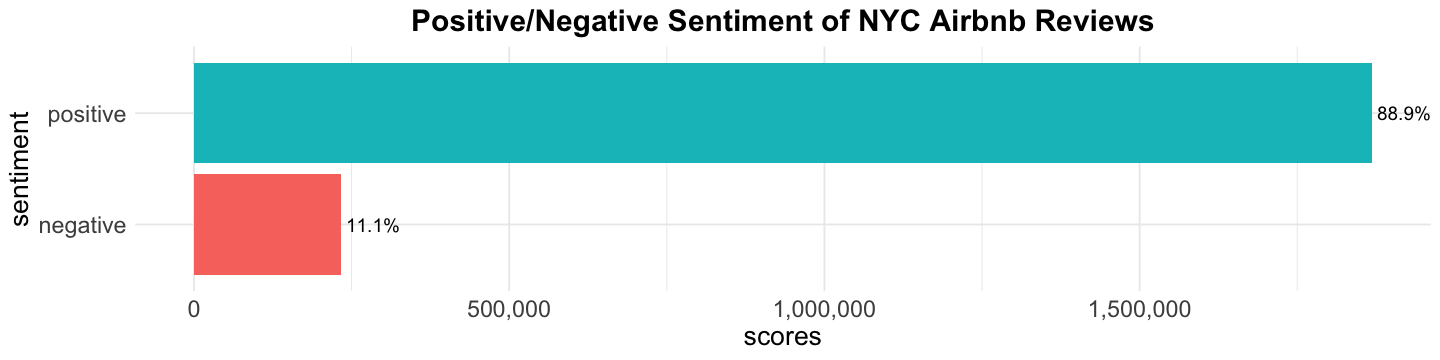

In [39]:
options(repr.plot.width = 12, repr.plot.height = 3)

barplot_sentiment(words_sentiments, "Positive/Negative Sentiment of NYC Airbnb Reviews")

Positive scores are much higher than negative scores. How did that change over time?

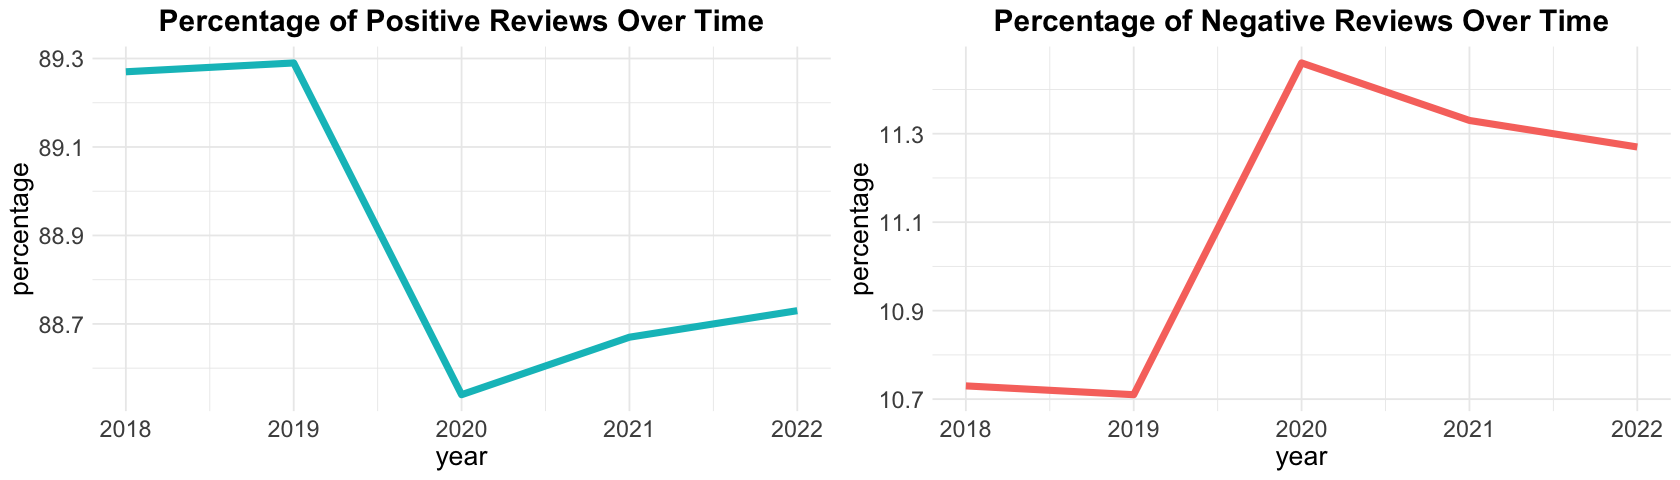

In [45]:
options(repr.plot.width = 14, repr.plot.height = 4)
# get percentage of sentiments group by year
sentiment_pcnt <- words_sentiments %>%
    mutate(quarter = format(date, "%Y")) %>%
    group_by(year) %>% 
    count(sentiment) %>%
    arrange(year, desc(n)) %>% 
    mutate(year = as.numeric(year),
           sentiment = reorder(sentiment, n), 
           percentage = round(n/sum(n)*100, digits = 2)) %>% 
    rename(scores = n)
# percentage of positive reviews
g1 <- sentiment_pcnt %>% 
  filter(sentiment %in% c("positive")) %>% 
  ggplot(aes(x=year, y=percentage)) + 
  geom_line(color="#00BFC4", size=2) + 
  theme(legend.position="none") +
  labs(title = "Percentage of Positive Reviews Over Time")
# percentage of negative reviews
g2 <- sentiment_pcnt %>% 
  filter(sentiment %in% c("negative")) %>% 
  ggplot(aes(x=year, y=percentage)) + 
  geom_line(color="#F8766D", size=2) + 
  theme(legend.position="none") +
  labs(title = "Percentage of Negative Reviews Over Time")

grid.arrange(g1, g2, ncol = 2) 

In 2018-2022, the percentage of positive reviews decreased first and then increased, while the percentage of negative reviews increased first and then decreased. Overall, the absolute percentage change was only 0.6%.

## 7. Results

In this project, we walk through a step-by-step introduction to text mining and sentiment analysis of NYC, Airbnb reviews, and found something interesting:

- The **location** of the listing is very important to guests, they care about the **walking distance** to **subway station**, and most often mentioned **5 minute walk** or **10 minute walk**.
- Reviews are more **positive** (88.9%) than negative (11.1%), the strongest emotions of reviews are **Trust** and **Joy**, which accounted for 61% of all emotions.
- Negative reviews are strongly associated with limited space, where **small room** leads to most negative reviews, followed by **small place** and **small apartment**.

## 8. Conclusion

This study focused on analyzing 743K+ reviews of Airbnb in New York City, 2018-2022. Exploratory data analysis was conducted to find the trend of number of reviews. Text mining and sentiment analysis was further implemented to find the most popular words, trend of popularity, reasons for negative reviews, and overall sentiment. This study can help lodging companies and hosts better understand user needs and improve customer satisfaction.
